# Preprocessing analysis

In this notebook we go over the preprocessing steps taken by Becker et al. (2023) ([code](https://github.com/prs-eth/bayes-forest-structure)). The input data consists of Sentinel-1 SAR images and Sentinel-2 band images. The output are tensor images of forest structure characteristics.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from pathlib import Path
from datetime import datetime
from itertools import chain
from collections import defaultdict
plt.rcParams["image.cmap"] = "Greens"

## 1. Sentinel-1 preprocessing

The sentinel-1 preprocessing pipeline uses the graph processing toolkit (GPT) ([docs](https://seadas.gsfc.nasa.gov/help-8.3.0/gpf/GraphProcessingTool.html)). The graph operations are defined by an XML file stored at `config/preocess_s1.xml`. The XML configuration file references a DEM file that seems to be related to `src/scripts/download_DEM.py`. The output is a tif file but does not seem to directly correspond to the data used by `src/scripts/prepare_dataset.py` (see section 3).

This [paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiTq-Dvl7j9AhVdhv0HHUMgCBYQFnoECAkQAQ&url=https%3A%2F%2Fwww.mdpi.com%2F2673-7418%2F2%2F4%2F24%2Fpdf&usg=AOvVaw18BPkrWZSUohLFtlgBsXok) proposes a workflow for Sentinel-1 preprocessing based on GPT. This may be useful.

## 2. Sentiel-2 preprocessing

This is unclear how the tif files are obtained.



## 3. Dataset preparation

The code in `src/scripts/prepare_dataset.py` uses shape files (geometry of the territories) and tif files (preprocessed satellite images, i.e. Sentinel-{1,2} reprojected) to generate the datasets. The configuration file associated to the script is `config/prepare_dataset.yaml`. 

As mentioned at the beginning of this notebook, the inputs consist of Sentinel-1 (s1) and Sentinel-2 (s2) pairs while the output are forest structure (fs) representation. It seems that the each data source (s1, s2, fs) is stored in a distinct folder but share a filename for a given sample, i.e a sample called `EXAMPLE` would have the following paths:
- s1: `data/sentinel_data/s1_reprojected/EXAMPLE/EXAMPLE_${other_informations}.tif`
- s2: `data/sentinel_data/s1_reprojected/EXAMPLE/EXAMPLE_${other_informations}.tif`
- fs: `data/preprocessed/EXAMPLE.tif`

In [2]:
from blowtorch import Run

run = Run(config_files=["config/prepare_dataset.yaml"])

In [3]:
project = 477

#### 3.1. Forest structures

Forest structures are described as tif files. 

In [4]:
import rasterio

fs_path = os.path.join(run["gt_dir"], f"{project}.tif")
fs_file = rasterio.open(fs_path)

As indicated in the configuration file (`config/prepare_dataset.yaml`), the forest structures are 5-dimensional tensors with shape [band, height, width]. the 5 bands are (in order):
1. p95
2. mean height
3. density
4. gini index
5. cover
There is also a validity mask accessible. Pixels corresponding to invalid locations, i.e `validity==0`, can be ignored, i.e set to `np.nan`.

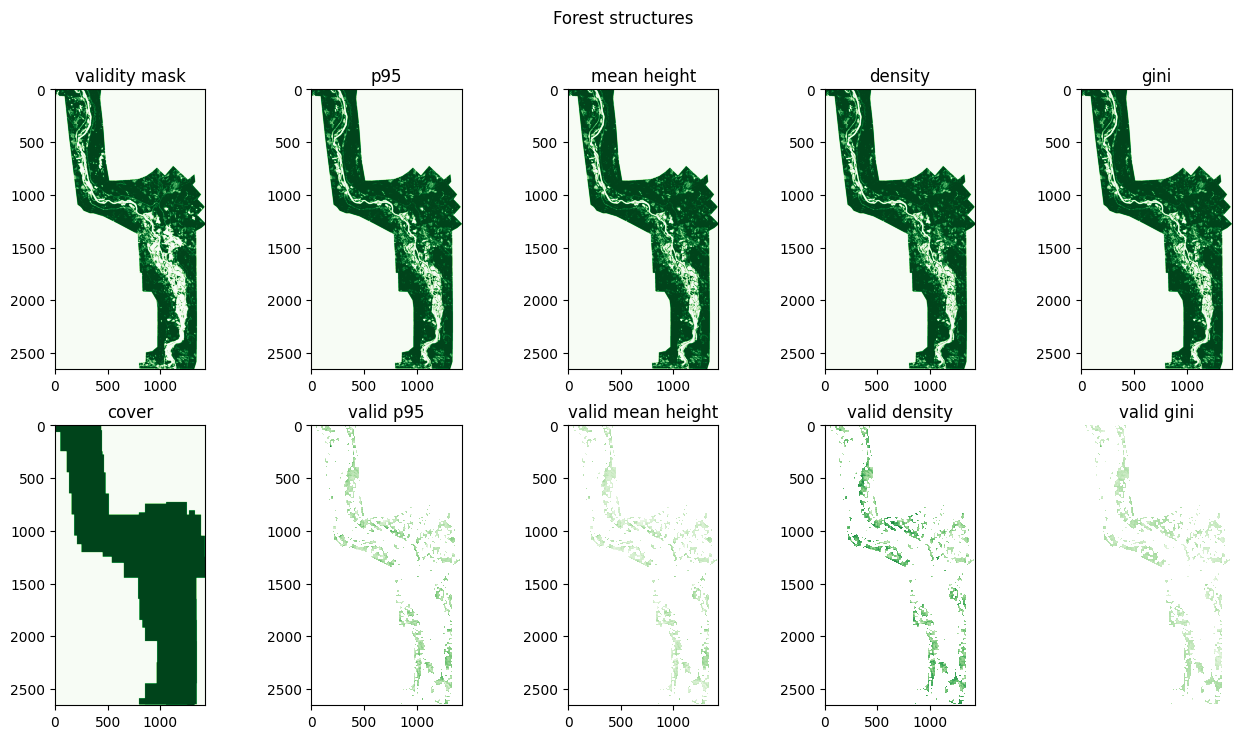

In [5]:
var_names = ["p95", "mean height", "density", "gini"]
# Read values
validity = fs_file.read_masks(1)
cover = fs_file.read(5)
fig, ax = plt.subplots(nrows=2, ncols=len(var_names)+1, figsize=(16,8))
for k in range(2):
    fs = fs_file.read([1,2,3,4,5])
    if k==1: fs[:,validity==0]=np.nan
    if k==0:
        ax[k,0].imshow(validity)
        ax[k,0].set_title("validity mask")
    else:
        ax[k,0].imshow(cover)
        ax[k,0].set_title("cover")
    for i, vn in enumerate(var_names):
        ax[k,i+1].imshow(fs[i])
        if k==0: ax[k,i+1].set_title(vn)
        else: ax[k,i+1].set_title(f"valid {vn}")
fig.suptitle("Forest structures")
plt.axis("off")
plt.show()


### 3.2. Shape files

Shape files are loaded with `fiona`. `fiona.open` returns a `Collection` object which is used to read/write/append shape files and manipulate them. Two shape files located at `data/NHM_projectDekning_AOI_edit2015_V2.shp` and `data/ALS_projects_Dz_all_norway.shp` are used.

In [17]:
import fiona

# read all shape files
project_shape_collections = [fiona.open(p) for p in run['project_shapefiles']]
# create the shape ("polygon") associated to the project 
polygon, crs = None, None
for collection in project_shape_collections:
    try:
        polygon = [s['geometry'] for s in collection if s['properties']['kv_id'] == int(Path(fs_path).stem)][0]
        crs = collection.crs
        break
    except IndexError: pass 
if polygon is None: print("No polygon found")

Before going any further, shape files must be projected to the same coordinate system as the labels using `rasterio.warp.transform_geom`.

In [18]:
import rasterio.warp
import rasterio.features

polygon = rasterio.warp.transform_geom(src_crs=crs, dst_crs=fs_file.crs, geom=polygon)
rasterized_polygon = rasterized_polygon = rasterio.features.rasterize(
    [(polygon, 1)],
    out_shape=fs_file.shape,
    transform=fs_file.transform,
    fill=0,
    dtype='uint8'
)

### 3.3. Sentinel data

The processed Sentinel images are large tif images associated to a timestamp. Here we simply collect the images and the dates in tuples. 

In [19]:
def parse_date(date_str) -> datetime:
    return datetime.strptime(date_str, '%Y%m%d')

#### 3.3.1. Sentinel-1 

Sentinel-1 images have two different orbits, ascending and descending.

In [26]:
s1_imgs_dir = Path(os.path.join(run["s1_reprojected_dir"], str(project))).glob("*.tif")
print("Collecting S1 images in {}".format(os.path.join(run["s1_reprojected_dir"], str(project))))
s1_asc, s1_desc = [], []
for img_path in s1_imgs_dir:
    with rasterio.open(img_path) as f:
        s1_list = s1_asc if img_path.stem.endswith("_A") else s1_desc# Final dataset iterables
        s1_list.append((
            f.read(f.indexes),
            parse_date(img_path.stem.split("_")[5].split("T")[0])
        ))
print("Found {} S1 images ({} asc, {} desc) associated to project {}".format(len(s1_asc)+len(s1_desc), len(s1_asc), len(s1_desc), project))

Found 11 S1 images (7 asc, 4 desc) associated to project 477


#### 3.3.2. Sentinel-2

Sentinel-2 images are more straightforward, there is no orbit differentiation.

In [27]:
s2_imgs_dir = Path(os.path.join(run["s2_reprojected_dir"], str(project))).glob("*.tif")
print("Collecting S2 images in {}".format(os.path.join(run["s2_reprojected_dir"], str(project))))
s2 = []
for img_path in s2_imgs_dir:
    with rasterio.open(img_path) as f:
        s2.append((
            f.read(f.indexes),
            parse_date(img_path.stem.split("_")[3].split("T")[0])
        ))
print("Found {} S2 images associated to project {}".format(len(s2), project))

Found 6 S2 images associated to project 477


#### 3.4. Dataset samples

Dataset samples have S1 and S2 images as inputs and forest structures as outputs. As the tifs representing the different regions are very large and not necessarily overlapping, we must recreate corresponding patches of information manually. The `split_mask` tensor specifies which cross validation set a certain patch belongs to. It is probably generated by `src/scripts/create_split_masks.py`.

To be more precise, the Sentinel-2 image is a 13-channels optical image while the Sential-1 image is a 4-channels (2 asc, 2 desc) SAR image. As multiple observations are available for a given patch, there are multiple inputs associated to a single output. I guess that the observation window is short enough so that we can assume that the forest structure stays constant (at least at the given resolution) across the observation span. 

In [28]:
# useful iterables
images = [img for img, _ in chain(s2, s1_asc, s1_desc)]
image_ids = [id(img) for img in images]
num_images_per_pixel = np.zeros((1, fs_file.shape[0], fs_file.shape[1]), dtype=np.uint8)
# split masks
split_mask = rasterio.open(os.path.join(run["split_mask_dir"], str(project)+".tif")).read(1).astype("float16")
# patch size
patch_half = run["patch_size"] // 2
# SEP
SEPARATOR = 65535

In [29]:
# Final dataset iterables
locations = defaultdict(list)
loc_to_images_map = defaultdict(list)
offsets = defaultdict(list)

In [30]:
# validity mask and valid labels
valid_mask = fs_file.read_masks(1)
labels = fs_file.read(run['data_bands'])
# set invalid gt points to nan
labels[:, valid_mask == 0] = np.nan

To generate the matching patches we create a nested loop that goes over the patches sequentially. Several conditions need to me met for a patch to be added to the dataset:
1. the patch must lie entirely in a single split to avoid duplicate data across the splits
2. the center pixel of the patch must be valid (why center? sounds arbitrary)
3. the patch must lie entirely in its respective polygon
Additionnally, Sentinel-1 images are further filtered by selecting only those where all the pixerls have a value greater than 8. 

In [34]:
for i in range(patch_half, fs_file.shape[0]-patch_half):
    for j in range(patch_half, fs_file.shape[1]-patch_half):
        # create slice objects
        i_slice = slice(i-patch_half, i+patch_half+1)
        j_slice = slice(j-patch_half, j+patch_half+1)
        # Ensure the selected patch is only in a single split
        is_same_split = (split_mask[i_slice, j_slice] == split_mask[i_slice, j_slice][0, 0]).all()
        # Ensure the selected patch is within the polygon of interest
        is_in_polygon = (rasterized_polygon[i_slice, j_slice] == 1).all()
        # Ensure the center pixel is valid
        is_valid_center = valid_mask[i,j]
        # Ensure all conditions are met
        is_ok = is_same_split and is_in_polygon and is_valid_center
        if is_ok:
            # If the patch is ok, we go through the images and select the matching ones
            images_for_pixel = []
            s2_dates_used = set()
            # s1 must have pixel > 8 (empirical, see code)
            valid_asc = [tup for tup in s1_asc if (tup[0][:,i_slice,j_slice]>8.).all()]
            valid_desc = [tup for tup in s1_desc if (tup[0][:,i_slice,j_slice]>8.).all()]
            if len(valid_asc)+len(valid_desc) == 0: continue
            # iterate over s2
            for img, date in s2:
                # No duplicate dates (see code for reason)
                if date in s2_dates_used: continue
                # No "nodata" point (i.e. 0 on all channels)
                if ((img[:,i_slice,j_slice]==0).all()).any(): continue
                # Only add patch that have less than the configured cloudy threshold
                cloudy_area = (img[-1,i_slice,j_slice]>run["cloud_prob_threshold"]).sum()
                total_area = run["patch_size"]**2
                if cloudy_area/total_area > run["cloudy_pixels_threshold"]: continue
                # Select corresponding s1
                match_asc = [s1_img for s1_img, s1_date in valid_asc if abs((date-s1_date).days)<=15]
                match_desc = [s1_img for s1_img, s1_date in valid_desc if abs((date-s1_date).days)<=15]
                # Create pairs
                if len(match_asc)+len(match_desc) > 0:
                    images_for_pixel.append((img, match_asc, match_desc))
                    s2_dates_used.add(date)
            # update images count
            num_images_per_pixel[0,i,j] = len(images_for_pixel)
            if len(images_for_pixel):
                images_for_pixel_map = []
                # Transform image_for_pixel into a contiguous np array
                for s2_img, s1_asc_imgs, s1_desc_imgs in images_for_pixel:            
                    images_for_pixel_map.extend(
                        [image_ids.index(id(s2_img)), SEPARATOR]
                        + [image_ids.index(id(img)) for img in s1_asc_imgs]
                        + [SEPARATOR]
                        + [image_ids.index(id(img)) for img in s1_desc_imgs]
                        + [SEPARATOR]
                    )
                # select split
                if split_mask[i, j] == 0:
                    dataset = 'train'
                elif split_mask[i, j] == 1:
                    dataset = 'val'
                elif split_mask[i, j] == 2:
                    dataset = 'test'
                else:
                    raise ValueError(split_mask[i, j])
                # add to dataset iterables
                locations[dataset].append((i,j))
                offsets[dataset].append(len(loc_to_images_map[dataset]))
                loc_to_images_map[dataset].extend(images_for_pixel_map)

At this point, all the data regarding the project of interest is put into a dictionary and saved at `data/forest_structure/pkl/$DATETIME_NOW/$PROJECT.pkl`. The dictionary has the following structure:

In [35]:
project_data = {
    "images": images, # all the images of the project
    "train": ( # train set info
        np.array(locations["val"], dtype=np.uint16),
        np.array(loc_to_images_map['train'], dtype=np.uint16),
        np.array(offsets['train'], dtype=np.uint64)
    ),
    'val': ( # val set info
        np.array(locations['val'], dtype=np.uint16),
        np.array(loc_to_images_map['val'], dtype=np.uint16),
        np.array(offsets['val'], dtype=np.uint64)
    ),
    'test': ( # test set info
        np.array(locations['test'], dtype=np.uint16),
        np.array(loc_to_images_map['test'], dtype=np.uint16),
        np.array(offsets['test'], dtype=np.uint64)
    ),
    'labels': labels # all labels
}

In more details, the FS, S1 and S2 images seem to have already been proprocessed to focus on the exact same area. The dataset therefore only really needs to references the patches within the images.
- `locations`: the patches center pixel coordinates
- `loc_to_images_map`: the indexes of the images in s1 and s2 (asc, desc) images lists (separated by `SEPARATOR:int`)
- `offsets`: offsets in the `loc_to_images_map` used to deliimit between samples
- `images`: list of all images
- `labels`: Forest structure labels

In [45]:
for key, value in project_data.items():
    if isinstance(value, tuple):
        value = [len(v) for v in list(value)]
    else:
        value = len(value)
    print(f"{key}: {value}")

images: 17
train: [105503, 13681836, 585907]
val: [105503, 2530640, 105503]
test: [102710, 2444000, 102710]
labels: 5


## 4. PyTorch batching

The steps presented above produce a directory of pickle files. Each pickle file is associated to a "project" identified by an integer, e.g. `data/pkl/2021-05-18_10-57-45/415.pkl`. Additional informations are also stored in the directory, such as `num_images_per_pixel_${project}.tif` which counts the number of images associated to each pixels and `stats.yaml` which contains statistics. In this section we explore the content of the `data/pkl/${datetime}/` directory and further look into the creation of PyTorch batches fed to the model.

In [58]:
from blowtorch import Run
run = Run(config_files=["config/resnext.yaml"])

### 4.1. Data exploration

In [ ]:
import rasterio
import pickle
import matplotlib.pyplot as plt
import numpy as np
project = 477

: 

In [78]:
def load_project(project, cfg):
    """Inspired by src.data.ForestData"""
    print("Loading project {}".format(project))
    # parse config
    root = Path(run["data.pkl_dir"])
    s2_image_bands = cfg["data.s2_image_bands"]
    s1_image_bands = cfg["data.s1_image_bands"]
    labels_bands = cfg["data.labels_bands"]
    # Find pickle file
    if pkl_file.stem in [p.stem for p in Path(root).glob("*.pkl")]: pkl_file = Path(os.path.join(root, f"{project}.pkl"))
    else: raise ValueError("{} not found in {}".format(project, root))
    # Parse pickle
    with pkl_file.open("rb") as h: data = pickle.load(h)
    for split in ["train", "val", "test"]:
        assert data[split][0].shape==data[split][2].shape[0] # same num of locations and offsets
        if data[split][0].shape[0]==0: print("The selected project has no {} data".format(split))
    

    # pickle dictionary
    project_pkl = Path(os.path.join(root, f"{project}.pkl"))
    with open(project_pkl, "rb") as h: project_data = pickle.load(h)
    # num_images per image
    num_images_per_pixel = rasterio.open(
        Path(os.path.join(root,f"num_images_per_pixel_{project}.tif"))
    ).read(1)
    return project_data, num_images_per_pixel

/usr/bin


In [79]:
project_data, num_images_per_pixel = load_project(project, run)

First let's look at the number of images per pixels.

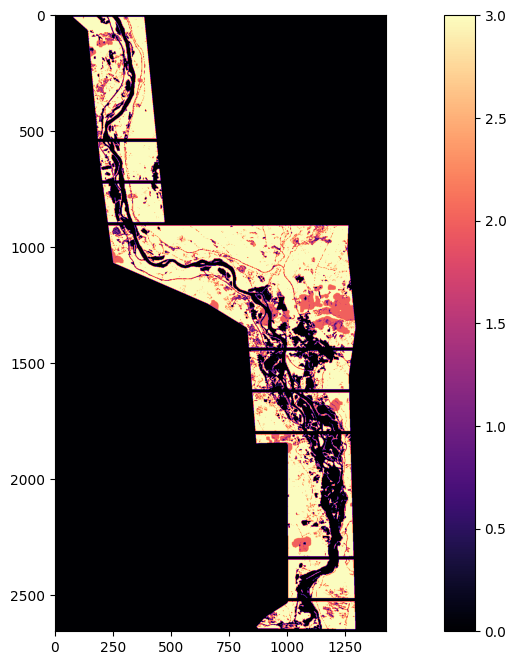

In [87]:
fig = plt.figure(figsize=(15,8))
plt.imshow(num_images_per_pixel, cmap="magma")
plt.colorbar()
plt.show()

Now we can have a look at the content of `project_data`.

In [94]:
labels = project_data["labels"]
images = project_data["images"]

In [99]:
len(run["data.s2_image_bands"])

12


In [96]:
# images are ordered as [s2_images + s1_asc_images + s1_desc_images]
s2_images, s1_images= [], []
for image in images:
    if image.shape[0]==len(run["data.s2_image_bands"]): s2_images.append(image)
    elif image.shape[0]==len(run["data.s1_image_bands"]): s1_images.append(image)
    else: print(image.shape)

(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)


In [93]:
print(labels.shape)
for image in images:
    print(image.shape)

(5, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(13, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)
(2, 2655, 1427)


In [ ]:
x = np.ones((4, 4))
y = np.random.randn(5,4,4)
np.hstack([
    x, np.full((len(x), 1), len(y), dtype=np.uint16)
])

: 